100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


MSE: 1.0422
MAE: 0.6881
MAPE: 822.2222%
RMSE: 1.0209
R-squared: -0.0364


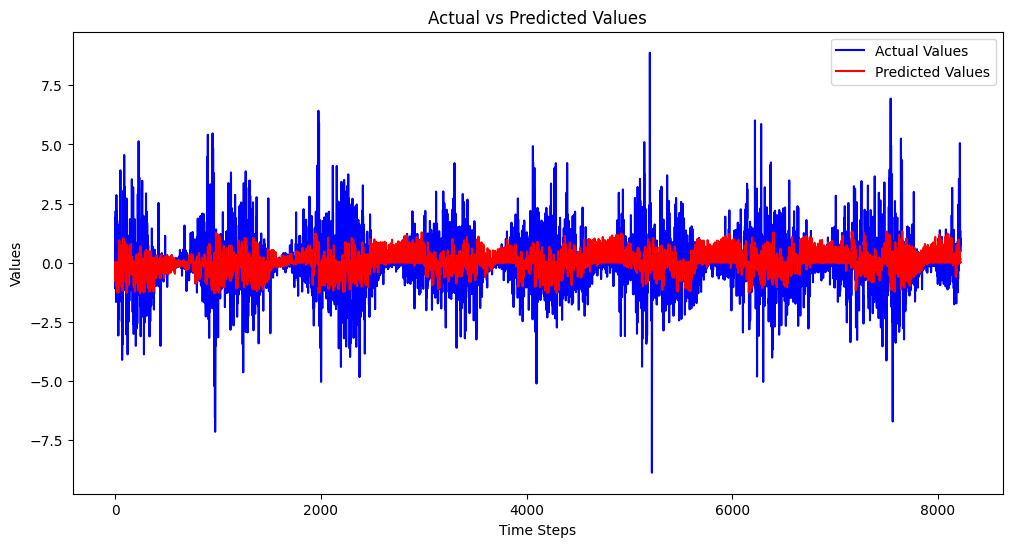

In [10]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=8)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

# Define the model
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = AGCRN(number_of_nodes=20,
                               in_channels=node_features,
                               out_channels=2,
                               K=2,
                               embedding_dimensions=4)
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

# Initialize model and optimizer
model = RecurrentGCN(node_features=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training phase
model.train()
e = torch.empty(20, 4)
torch.nn.init.xavier_uniform_(e)

for epoch in tqdm(range(200)):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, 20, 8)
        y_hat, h = model(x, e, h)
        cost += torch.mean((y_hat - snapshot.y) ** 2)  # MSE for training loss
    cost /= (time + 1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation phase
model.eval()
predictions = []  # List to store predictions
actuals = []      # List to store actual values

for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, 20, 8)
    y_hat, h = model(x, e, h)
    
    # Store predictions and actual values
    predictions.append(y_hat.detach().cpu().numpy())
    actuals.append(snapshot.y.detach().cpu().numpy())

# Convert lists to numpy arrays for easier handling if needed
predictions = np.array(predictions).squeeze()  # Remove extra dimensions if necessary
actuals = np.array(actuals).squeeze()

# Calculate evaluation metrics
mse = np.mean((predictions - actuals) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(predictions - actuals))  # Mean Absolute Error

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((predictions - actuals) / actuals)) * 100

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# R-squared (Coefficient of Determination)
ss_total = np.sum((actuals - np.mean(actuals)) ** 2)
ss_residual = np.sum((actuals - predictions) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Print evaluation metrics
print("MSE: {:.4f}".format(mse))
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r_squared))

# Optional: Visualize results
plt.figure(figsize=(12, 6))
plt.plot(actuals.flatten(), label='Actual Values', color='blue')
plt.plot(predictions.flatten(), label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()